In [8]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Masking,Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed,MaxPooling1D, Flatten, Conv1D,Conv2D,Dropout, MaxPooling2D # for creating layers inside the Neural Network
from keras.optimizers import Adam , SGD
# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import numpy.ma as ma
# Sklearn
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for feature scaling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model
# Visualization
import plotly 
import plotly.express as px
import plotly.graph_objects as go
print('plotly: %s' % plotly.__version__) # print version
from matplotlib import pyplot as plt

#file accessing
import os
# time stuff
from datetime import timedelta
import calendar


Tensorflow/Keras: 2.9.0
pandas: 1.4.2
numpy: 1.22.4
sklearn: 1.1.1
plotly: 5.9.0


In [9]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against the training feature and label."""

  # Label the axes.
  plt.xlabel("feature")
  plt.ylabel("label")

  # Plot the feature values vs. label values.
  plt.scatter(feature, label)

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = feature[-1]
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()

def plot_the_loss_curve(epochs, rmse):
  """Plot the loss curve, which shows loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")
  #epochs.remove(max(epochs))
  
  #rmse.drop(max(rmse))
  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


##### Read from file and establish dataframe and future functions

In [10]:
df=pd.read_csv('E:\DSFellowship\Complete\dataset2\dataset2.csv')
df=df.set_index([df.columns[0],df.columns[1]])
df.columns=pd.to_datetime(df.columns, format='%Y-%m-%d')
df=df.dropna(axis=0, how='all')#drop full nan rows

##### Remove next line to include all data

In [11]:
#df=df.iloc[500000:510000] #cuts data to long 120-119 approx
df

,,2014-11-08,2014-12-02,2014-12-26,2015-02-12,2015-03-08,2015-04-01,2015-04-25,2015-05-19,2015-06-12,2015-07-06,...,2018-10-18,2018-10-30,2018-11-11,2018-11-17,2018-11-23,2018-12-05,2018-12-17,2018-12-29,2019-01-10,2019-01-22
Longitude,Latitude,,,,,,,,,,,,,,,,,,,,,
-120.3387,36.5393,0.0,-6.2129,3.4247,5.7830,2.13990,6.8538,1.83540,2.1142,1.83670,-1.5935,...,4.93520,8.059200,6.39190,6.56470,3.58430,5.337900,7.14430,9.1285,8.73970,10.38400
-120.1908,36.1412,0.0,-5.6951,2.2257,4.5835,1.70790,6.5348,2.98530,2.7613,3.76730,2.2235,...,6.28560,8.606700,7.15330,8.06940,5.60730,4.977600,8.18450,9.0591,8.89620,10.35300
-119.8869,35.6171,0.0,-6.7674,1.8611,3.5773,0.77856,4.5700,1.90460,2.8225,0.89615,2.6578,...,6.42140,7.527900,6.25500,7.12750,7.43410,3.680000,6.77130,8.8868,7.87950,9.15160
-119.8849,35.8671,0.0,-6.9006,1.5378,3.1628,0.49591,5.3001,1.69690,2.4262,1.60660,1.9497,...,6.71270,8.195900,6.89780,7.72280,7.08070,5.015800,6.95200,8.8647,8.17390,9.19100
-119.8829,35.9512,0.0,-6.3572,1.1703,2.1735,-0.47235,3.9732,0.57705,1.4311,0.69616,1.1763,...,5.86560,7.390000,6.27260,7.15710,5.54560,3.736800,6.18420,7.5924,6.51850,8.10940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-118.9071,35.3750,0.0,-3.8828,-1.1999,-1.2152,-2.12550,-3.4199,-0.94401,-3.6226,0.56910,-1.4506,...,2.44230,2.689300,3.37490,3.22130,3.32230,2.285500,1.94290,5.8860,2.26160,2.42750
-118.9051,35.3430,0.0,-4.1356,-1.1255,-1.2232,-2.18530,-3.3244,-0.70324,-3.5807,0.53279,-1.5025,...,1.45350,1.393300,2.12930,1.83520,2.14240,1.547400,1.06060,4.7605,0.96871,1.18650
-118.9031,35.3110,0.0,-4.1879,-1.1213,-1.7977,-2.28030,-3.4793,-0.84339,-3.6445,0.30264,-2.1569,...,-0.17429,0.098737,0.56824,0.16814,0.69418,-0.011814,-0.57993,2.7450,-1.03220,-0.71361


# Timestep

In [12]:
timestep=10

# Shaping function (remove start and step for first for loop to include all data)

In [13]:
def shaping3(datain,datain2,datain3 ,timestep, features):
    #print(arr)
    cnt=0
    for row in range(len(datain.index)): #picks a row at every iteration, allows to reduction of input and inclusion of multiple time series, remove start and step to run on full dataset 
    # Convert input dataframe to array and flatten

        # if datain.index[row] not in datain2.index:
        #     #print("Not found", cnt)
        #     continue
        
        #arr1=scaler.fit_transform(datain2.loc[datain.index[row]].to_numpy().flatten().reshape(-1,datain2.loc[datain.index[row]].shape[-1])).reshape(datain2.loc[datain.index[row]].shape)
        #arr2=scaler.fit_transform(datain3.loc[datain.index[row]].to_numpy().flatten().reshape(-1,datain3.loc[datain.index[row]].shape[-1])).reshape(datain3.loc[datain.index[row]].shape)
        
        arr1=datain2.loc[datain.index[row]].to_numpy().flatten()
        arr2=datain3.loc[datain.index[row]].to_numpy().flatten()
        arr=datain.iloc[row].interpolate().to_numpy().flatten()
        #arr=scaler.fit_transform(arr.reshape(-1,arr.shape[-1])).reshape(arr.shape)

        # arr1=datain3.loc[datain.index[row]].to_numpy().flatten()
        # # print("found", row)
        # arr2=datain2.loc[datain.index[row]].to_numpy().flatten() # rainfall
         
        
        #arr2=np.where(np.isnan(arr2), ma.array(arr2, mask=np.isnan(arr2)).mean(), arr2) 
        arr3=np.concatenate((arr,arr2,arr1)).reshape(features,110)
        
        
        for mth in range(0, len(datain2.columns)-(2*timestep)+1): # Define range lenght of the dates - 2* amount of timesep?? +1
            cnt=cnt+1 # Gives us the number of samples. Later used to reshape the data
            X_start=mth # Start month for inputs of each sample
            X_end=mth+timestep # End month for inputs of each sample
            Y_start=mth+timestep # Start month for targets of each sample. Note, start is inclusive and end is exclusive, that's why X_end and Y_start is the same number
            Y_end=mth+2*timestep # End month for targets of each sample.  
            
            # Assemble input and target arrays containing all samples
            if cnt==1:
                X_comb=arr3[:,X_start:X_end]
                #arr3=scaler.inverse_transform(arr3.reshape(-1,arr3.shape[-1])).reshape(arr3.shape)
                Y_comb=arr3[0][Y_start:Y_end]
            else: 
                X_comb=np.append(X_comb, arr3[:,X_start:X_end])
                #arr3=scaler.inverse_transform(arr3.reshape(-1,arr3.shape[-1])).reshape(arr3.shape)
                Y_comb=np.append(Y_comb, arr3[:1,Y_start:Y_end])
    
    # Reshape input and target arrays
    X_out=np.reshape(X_comb, (cnt, timestep, features))
    Y_out=np.reshape(Y_comb, (cnt, timestep, 1))
    return X_out, Y_out

In [14]:
dfgw=pd.read_csv('E:\DSFellowship\InSAR_data_south/displacement/groundwater.csv')

dfgw=dfgw.set_index([dfgw.columns[0],dfgw.columns[1]])
dfgw.columns=pd.to_datetime(dfgw.columns, format='%Y-%m-%d')
dfgw=dfgw.dropna(axis=0, how='all')#drop full nan rows
for y in range(df.columns.size):# includes all dates and adds nans
    if df.columns[y] != dfgw.columns[y]: #if column is misssing insert it
        dfgw.insert(loc=y,column=df.columns[y],value=np.nan*237,allow_duplicates=False)
for x in range(len(dfgw.index)):
    dfgw.iloc[x]=dfgw.iloc[x].fillna(method='ffill')
    dfgw.iloc[x]=dfgw.iloc[x].fillna(method='bfill')

In [15]:
drain=pd.read_csv('E:\DSFellowship\InSAR_data_south/displacement/rainfall.csv')
drain=drain.set_index([drain.columns[0],drain.columns[1]])
drain.columns=pd.to_datetime(drain.columns, format='%Y-%m-%d')
for y in range(df.columns.size):# includes all dates and adds nans
    if df.columns[y] != drain.columns[y]: #if column is misssing insert it
        drain.insert(loc=y,column=df.columns[y],value=np.nan*237,allow_duplicates=False)
drain

C:\Users\jupad\AppData\Local\Temp\ipykernel_27904\4243083038.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  drain.insert(loc=y,column=df.columns[y],value=np.nan*237,allow_duplicates=False)


,,2014-11-08,2014-12-02,2014-12-26,2015-02-12,2015-03-08,2015-04-01,2015-04-25,2015-05-19,2015-06-12,2015-07-06,...,2018-10-18,2018-10-30,2018-11-11,2018-11-17,2018-11-23,2018-12-05,2018-12-17,2018-12-29,2019-01-10,2019-01-22
Longitude,Latitude,,,,,,,,,,,,,,,,,,,,,
-120.9486,37.6316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.002529e-08,5.244156e-15,3.241600e-13,0.0,19.307816,64.067047,31.963058,25.633082,28.319157,59.736828
-120.8926,36.7114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.529937,41.590660,20.704192,29.202840,14.592794,11.388287
-120.8846,36.6994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.653009,42.319168,20.722277,29.526450,14.602126,11.487171
-120.8746,36.6874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.783698,43.095787,20.731019,29.834099,14.613811,11.625130
-120.1368,35.6991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.111030e-01,1.693514e-02,1.218172e+00,0.0,33.671449,152.541073,14.180448,23.243916,62.997394,122.872945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-119.0351,36.3933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.021634e+00,0.000000e+00,2.206239e-07,0.0,37.236885,134.395294,8.690165,34.406051,84.547653,165.973335
-119.0271,36.3793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.355278e+00,0.000000e+00,5.527269e-09,0.0,37.965350,138.551914,10.061119,37.785093,91.544703,176.264024
-119.0571,36.4493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.488359e+00,2.814860e-11,0.000000e+00,0.0,37.284857,126.509520,4.650238,25.860381,65.558802,137.376688


In [16]:
drain=drain.transpose()
for x in drain.columns.values:
    drain[x].fillna(drain[x].mean(),inplace=True)
drain=drain.transpose()
drain

,,2014-11-08,2014-12-02,2014-12-26,2015-02-12,2015-03-08,2015-04-01,2015-04-25,2015-05-19,2015-06-12,2015-07-06,...,2018-10-18,2018-10-30,2018-11-11,2018-11-17,2018-11-23,2018-12-05,2018-12-17,2018-12-29,2019-01-10,2019-01-22
Longitude,Latitude,,,,,,,,,,,,,,,,,,,,,
-120.9486,37.6316,14.100342,14.100342,14.100342,14.100342,14.100342,14.100342,14.100342,14.100342,14.100342,14.100342,...,1.002529e-08,5.244156e-15,3.241600e-13,0.0,19.307816,64.067047,31.963058,25.633082,28.319157,59.736828
-120.8926,36.7114,10.444028,10.444028,10.444028,10.444028,10.444028,10.444028,10.444028,10.444028,10.444028,10.444028,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.529937,41.590660,20.704192,29.202840,14.592794,11.388287
-120.8846,36.6994,10.456846,10.456846,10.456846,10.456846,10.456846,10.456846,10.456846,10.456846,10.456846,10.456846,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.653009,42.319168,20.722277,29.526450,14.602126,11.487171
-120.8746,36.6874,10.468676,10.468676,10.468676,10.468676,10.468676,10.468676,10.468676,10.468676,10.468676,10.468676,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10.783698,43.095787,20.731019,29.834099,14.613811,11.625130
-120.1368,35.6991,39.903783,39.903783,39.903783,39.903783,39.903783,39.903783,39.903783,39.903783,39.903783,39.903783,...,3.111030e-01,1.693514e-02,1.218172e+00,0.0,33.671449,152.541073,14.180448,23.243916,62.997394,122.872945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-119.0351,36.3933,45.279917,45.279917,45.279917,45.279917,45.279917,45.279917,45.279917,45.279917,45.279917,45.279917,...,5.021634e+00,0.000000e+00,2.206239e-07,0.0,37.236885,134.395294,8.690165,34.406051,84.547653,165.973335
-119.0271,36.3793,48.352180,48.352180,48.352180,48.352180,48.352180,48.352180,48.352180,48.352180,48.352180,48.352180,...,5.355278e+00,0.000000e+00,5.527269e-09,0.0,37.965350,138.551914,10.061119,37.785093,91.544703,176.264024
-119.0571,36.4493,36.942623,36.942623,36.942623,36.942623,36.942623,36.942623,36.942623,36.942623,36.942623,36.942623,...,4.488359e+00,2.814860e-11,0.000000e+00,0.0,37.284857,126.509520,4.650238,25.860381,65.558802,137.376688


##### Step 2 - Split and Shape data

In [17]:



features=3

train, test=train_test_split(df,test_size=.2,shuffle=True,random_state=42)
X_train, Y_train = shaping3(datain=train,datain2=drain,datain3=dfgw, timestep= timestep,features=features )


X_test, Y_test = shaping3(datain=test,datain2=drain,datain3=dfgw, timestep= timestep,features=features )

nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = Y_train.shape
Y_train = Y_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))
nsamples, nx, ny = Y_test.shape
Y_test = Y_test.reshape((nsamples,nx*ny))
print(train.size)
print(test.size)

53020
13310


##### Step 3 - Specify the structure of a Neural Network, first model

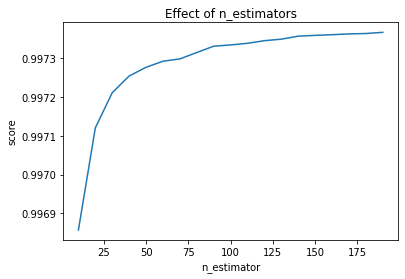

In [18]:
# set model
model = RandomForestRegressor(n_jobs = -1, random_state = 64)
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, Y_train)
    scores.append(model.score(X_test, Y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)



##### Train model

##### Step 4 - Plot loss over epochs

In [19]:
# Predicting the target values of the test set
Y_pred = model.predict(X_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(Y_test, Y_pred)), '.3f'))
print("\nRMSE: ", rmse)
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))



RMSE:  1.196
Mean Absolute Error: 0.8216671794132001
Mean Squared Error: 1.4300673209365384
Root Mean Squared Error: 1.1958542222765025


In [20]:
#Mean Squared Error: 5.603327831842854 improved to  4.261887821881056 adding features
# Calculate the absolute errors
errors = abs(Y_pred - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_test)
# Calculate and display accuracy


Mean Absolute Error: 0.82 degrees.
Accuracy: 103.14 %.


c:\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


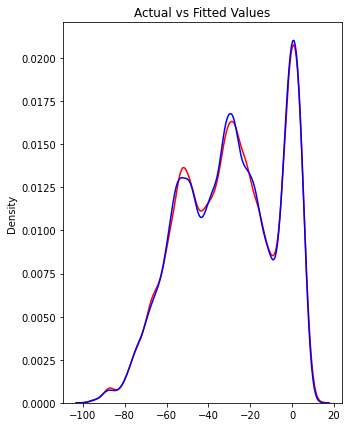

In [21]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.distplot(Y_test, hist=False, color="r", label="Actual Value")
sns.distplot(Y_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [22]:
##### Step 5 - Print Performance Summary